In [72]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import warnings
import gc
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
%matplotlib inline

stack_models = []

In [73]:
# dataの読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv',header=None)

In [74]:
# データの量の確認
train_df.shape,test_df.shape,submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [75]:
# 訓練データ、テストデータがわかるようにダミーの目的変数を代入
test_df['y']=-999

In [76]:
# 訓練データ、テストデータを結合
all_df = pd.concat([train_df,test_df])
del train_df,test_df
gc.collect()

7883

In [77]:
# sec1
def sec1():
    age_bining = pd.cut(all_df['age'], [19,30,40,50,60,100])
    age_bining

    duration_bining = pd.cut(all_df['duration'], [-1, 100,200,300,400,500,600,700,800,900,1000,5000])
    duration_bining

    all_df['age_bining'] = age_bining
    all_df['duration_bining'] = duration_bining


In [78]:
# sec1()

In [79]:
cols_o = all_df.select_dtypes(exclude='int64').columns.tolist()
cols_o

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [80]:
for i, col in enumerate(cols_o):
    print(i, col, all_df[col].nunique())
    
all_df[cols_o].isnull().any()

0 job 12
1 marital 3
2 education 4
3 default 2
4 housing 2
5 loan 2
6 contact 3
7 month 11
8 poutcome 4


job          False
marital      False
education    False
default      False
housing      False
loan         False
contact      False
month        False
poutcome     False
dtype: bool

In [81]:
# カテゴリカラムの前処理
categorical_features = cols_o
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])

In [82]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         45150 non-null  int64
 1   age        45150 non-null  int64
 2   job        45150 non-null  int32
 3   marital    45150 non-null  int32
 4   education  45150 non-null  int32
 5   default    45150 non-null  int32
 6   balance    45150 non-null  int64
 7   housing    45150 non-null  int32
 8   loan       45150 non-null  int32
 9   contact    45150 non-null  int32
 10  day        45150 non-null  int64
 11  month      45150 non-null  int32
 12  duration   45150 non-null  int64
 13  campaign   45150 non-null  int64
 14  pdays      45150 non-null  int64
 15  previous   45150 non-null  int64
 16  poutcome   45150 non-null  int32
 17  y          45150 non-null  int64
dtypes: int32(9), int64(9)
memory usage: 5.0 MB


In [83]:
# 訓練データ、テストデータの分割
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [84]:
y_train_org = train_df['y']
X_train_org = train_df.drop(['y','id'], axis=1)
X_test = test_df.drop(['y','id'], axis=1)
X_all = pd.concat([X_train_org, X_test], axis=0, ignore_index=True)

In [85]:
# 訓練データからデータを分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train_org, y_train_org, test_size=0.3, random_state=0, stratify=y_train_org)
X_train.shape,X_valid.shape,y_train.shape, y_valid.shape, X_test.shape, X_all.shape

((18970, 16), (8130, 16), (18970,), (8130,), (18050, 16), (45150, 16))

## LightGBM

In [86]:
# 使用モデルはLGB（パラメータチューニング無）
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

lgb_params = {
    'objective': 'binary', 
    'metric': 'auc',
    'random_state': 1,
}

lgb_model = lgb.train(
    lgb_params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)


Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.855071	valid_1's auc: 0.820871
[20]	training's auc: 0.886697	valid_1's auc: 0.83824
[30]	training's auc: 0.904365	valid_1's auc: 0.845185
[40]	training's auc: 0.917194	valid_1's auc: 0.84569
Early stopping, best iteration is:
[32]	training's auc: 0.907379	valid_1's auc: 0.845823


In [87]:
stack_models.append(lgb_model)
lgb_y_pred = lgb_model.predict(X_train_org, num_iteration=lgb_model.best_iteration)
lgb_y_pred

array([0.02055918, 0.09210184, 0.00737603, ..., 0.06858891, 0.04574923,
       0.00575055])

In [88]:
lgb_y_pred = np.where(lgb_y_pred > 0.5, 1, 0)
lgb_y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
lgb_y_pred.shape

(27100,)

In [90]:
metrics.roc_auc_score(y_train_org, lgb_y_pred)

# default : 0.6252230237180513


0.6063036393832676

In [91]:
lgb_y_pred.shape

(27100,)

In [92]:
all_pred = pd.DataFrame()
all_pred['y'] = all_df['y']
all_pred['lgb'] = lgb_model.predict(X_all, num_iteration=lgb_model.best_iteration)


In [93]:
def submit(y_pred, name, submit):
    submit_df[1]=y_pred
    submit_df.to_csv('submit_'+name+'_20200808.csv',index=False,header=None)


In [94]:
lgb_submit = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
lgb_submit

submit(lgb_submit, 'lgb', submit_df)

## XGBoost

In [95]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'seed': 1,
    'eval_metric': 'auc',
}

# モデルを学習する
xgb_model = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=1000,  # 学習ラウンド数は適当
)

[0]	train-auc:0.78118	eval-auc:0.74632
[1]	train-auc:0.80741	eval-auc:0.77492
[2]	train-auc:0.81604	eval-auc:0.78100
[3]	train-auc:0.83010	eval-auc:0.79253
[4]	train-auc:0.84072	eval-auc:0.80271
[5]	train-auc:0.84421	eval-auc:0.80460
[6]	train-auc:0.85198	eval-auc:0.80856
[7]	train-auc:0.85857	eval-auc:0.81126
[8]	train-auc:0.86425	eval-auc:0.81404
[9]	train-auc:0.87316	eval-auc:0.81767
[10]	train-auc:0.87862	eval-auc:0.82230
[11]	train-auc:0.88364	eval-auc:0.82392
[12]	train-auc:0.88901	eval-auc:0.82636
[13]	train-auc:0.89321	eval-auc:0.82946
[14]	train-auc:0.89806	eval-auc:0.83010
[15]	train-auc:0.90078	eval-auc:0.83261
[16]	train-auc:0.90663	eval-auc:0.83415
[17]	train-auc:0.90827	eval-auc:0.83507
[18]	train-auc:0.91228	eval-auc:0.83584
[19]	train-auc:0.91513	eval-auc:0.83522
[20]	train-auc:0.91784	eval-auc:0.83497
[21]	train-auc:0.92306	eval-auc:0.83528
[22]	train-auc:0.92440	eval-auc:0.83565
[23]	train-auc:0.92639	eval-auc:0.83558
[24]	train-auc:0.92957	eval-auc:0.83607
[25]	train

[203]	train-auc:0.99955	eval-auc:0.81315
[204]	train-auc:0.99956	eval-auc:0.81292
[205]	train-auc:0.99958	eval-auc:0.81288
[206]	train-auc:0.99960	eval-auc:0.81280
[207]	train-auc:0.99960	eval-auc:0.81276
[208]	train-auc:0.99960	eval-auc:0.81274
[209]	train-auc:0.99961	eval-auc:0.81262
[210]	train-auc:0.99966	eval-auc:0.81245
[211]	train-auc:0.99967	eval-auc:0.81209
[212]	train-auc:0.99967	eval-auc:0.81212
[213]	train-auc:0.99972	eval-auc:0.81218
[214]	train-auc:0.99973	eval-auc:0.81250
[215]	train-auc:0.99974	eval-auc:0.81230
[216]	train-auc:0.99976	eval-auc:0.81212
[217]	train-auc:0.99977	eval-auc:0.81185
[218]	train-auc:0.99977	eval-auc:0.81198
[219]	train-auc:0.99979	eval-auc:0.81185
[220]	train-auc:0.99979	eval-auc:0.81161
[221]	train-auc:0.99979	eval-auc:0.81148
[222]	train-auc:0.99979	eval-auc:0.81135
[223]	train-auc:0.99981	eval-auc:0.81125
[224]	train-auc:0.99983	eval-auc:0.81121
[225]	train-auc:0.99984	eval-auc:0.81085
[226]	train-auc:0.99984	eval-auc:0.81063
[227]	train-auc:

[403]	train-auc:1.00000	eval-auc:0.80740
[404]	train-auc:1.00000	eval-auc:0.80732
[405]	train-auc:1.00000	eval-auc:0.80731
[406]	train-auc:1.00000	eval-auc:0.80710
[407]	train-auc:1.00000	eval-auc:0.80717
[408]	train-auc:1.00000	eval-auc:0.80715
[409]	train-auc:1.00000	eval-auc:0.80712
[410]	train-auc:1.00000	eval-auc:0.80705
[411]	train-auc:1.00000	eval-auc:0.80712
[412]	train-auc:1.00000	eval-auc:0.80715
[413]	train-auc:1.00000	eval-auc:0.80713
[414]	train-auc:1.00000	eval-auc:0.80713
[415]	train-auc:1.00000	eval-auc:0.80694
[416]	train-auc:1.00000	eval-auc:0.80707
[417]	train-auc:1.00000	eval-auc:0.80708
[418]	train-auc:1.00000	eval-auc:0.80741
[419]	train-auc:1.00000	eval-auc:0.80747
[420]	train-auc:1.00000	eval-auc:0.80768
[421]	train-auc:1.00000	eval-auc:0.80759
[422]	train-auc:1.00000	eval-auc:0.80773
[423]	train-auc:1.00000	eval-auc:0.80744
[424]	train-auc:1.00000	eval-auc:0.80736
[425]	train-auc:1.00000	eval-auc:0.80739
[426]	train-auc:1.00000	eval-auc:0.80743
[427]	train-auc:

[603]	train-auc:1.00000	eval-auc:0.80191
[604]	train-auc:1.00000	eval-auc:0.80188
[605]	train-auc:1.00000	eval-auc:0.80180
[606]	train-auc:1.00000	eval-auc:0.80180
[607]	train-auc:1.00000	eval-auc:0.80181
[608]	train-auc:1.00000	eval-auc:0.80179
[609]	train-auc:1.00000	eval-auc:0.80172
[610]	train-auc:1.00000	eval-auc:0.80187
[611]	train-auc:1.00000	eval-auc:0.80179
[612]	train-auc:1.00000	eval-auc:0.80165
[613]	train-auc:1.00000	eval-auc:0.80173
[614]	train-auc:1.00000	eval-auc:0.80190
[615]	train-auc:1.00000	eval-auc:0.80188
[616]	train-auc:1.00000	eval-auc:0.80192
[617]	train-auc:1.00000	eval-auc:0.80186
[618]	train-auc:1.00000	eval-auc:0.80175
[619]	train-auc:1.00000	eval-auc:0.80172
[620]	train-auc:1.00000	eval-auc:0.80173
[621]	train-auc:1.00000	eval-auc:0.80195
[622]	train-auc:1.00000	eval-auc:0.80201
[623]	train-auc:1.00000	eval-auc:0.80195
[624]	train-auc:1.00000	eval-auc:0.80206
[625]	train-auc:1.00000	eval-auc:0.80209
[626]	train-auc:1.00000	eval-auc:0.80220
[627]	train-auc:

[803]	train-auc:1.00000	eval-auc:0.80032
[804]	train-auc:1.00000	eval-auc:0.80031
[805]	train-auc:1.00000	eval-auc:0.80026
[806]	train-auc:1.00000	eval-auc:0.80028
[807]	train-auc:1.00000	eval-auc:0.80030
[808]	train-auc:1.00000	eval-auc:0.80031
[809]	train-auc:1.00000	eval-auc:0.80028
[810]	train-auc:1.00000	eval-auc:0.80021
[811]	train-auc:1.00000	eval-auc:0.80040
[812]	train-auc:1.00000	eval-auc:0.80033
[813]	train-auc:1.00000	eval-auc:0.80045
[814]	train-auc:1.00000	eval-auc:0.80039
[815]	train-auc:1.00000	eval-auc:0.80035
[816]	train-auc:1.00000	eval-auc:0.80026
[817]	train-auc:1.00000	eval-auc:0.80028
[818]	train-auc:1.00000	eval-auc:0.80035
[819]	train-auc:1.00000	eval-auc:0.80031
[820]	train-auc:1.00000	eval-auc:0.80025
[821]	train-auc:1.00000	eval-auc:0.80040
[822]	train-auc:1.00000	eval-auc:0.80038
[823]	train-auc:1.00000	eval-auc:0.80044
[824]	train-auc:1.00000	eval-auc:0.80058
[825]	train-auc:1.00000	eval-auc:0.80055
[826]	train-auc:1.00000	eval-auc:0.80055
[827]	train-auc:

In [96]:
y_valid.shape

(8130,)

In [97]:
stack_models.append(xgb_model)
xgb_y_pred = xgb_model.predict(xgb.DMatrix(X_train_org, label=y_train_org))
xgb_y_pred

array([1.8573752e-05, 9.8837495e-01, 3.1320953e-06, ..., 7.2439276e-03,
       1.0513149e-03, 6.6386627e-07], dtype=float32)

In [98]:
xgb_y_pred = np.where(xgb_y_pred > 0.5, 1, 0)
xgb_y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [99]:
metrics.roc_auc_score(y_train_org, xgb_y_pred)

# default : 0.8812548962896131


0.8812548962896131

In [100]:
xgb_y_pred.shape

(27100,)

In [101]:
all_pred['xgb'] = xgb_model.predict(xgb.DMatrix(X_all))


In [102]:
xgb_submit = xgb_model.predict(xgb.DMatrix(X_test))
xgb_submit

submit(xgb_submit, 'xgb', submit_df)

## random forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
random_forest.fit(X_train_org, y_train_org)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [104]:
stack_models.append(random_forest)
rf_y_pred = random_forest.predict(X_train_org)
rf_y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [105]:
rf_y_pred = np.where(rf_y_pred > 0.5, 1, 0)
rf_y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [106]:
metrics.roc_auc_score(y_train_org, rf_y_pred)

# default : 0.5408730281444184


0.5408730281444184

In [107]:
all_pred['rf'] = random_forest.predict(X_all)


In [108]:
rf_submit = random_forest.predict(X_test)
rf_submit

submit(rf_submit, 'rf', submit_df)

In [109]:
all_pred

,y,lgb,xgb,rf
0,0,0.020559,0.000019,0
1,1,0.092102,0.988375,0
2,0,0.007376,0.000003,0
3,0,0.016858,0.000006,0
4,0,0.172752,0.000390,0
...,...,...,...,...
18045,-999,0.022991,0.000003,0
18046,-999,0.008108,0.000004,0
18047,-999,0.067578,0.024460,0
18048,-999,0.011797,0.000001,0


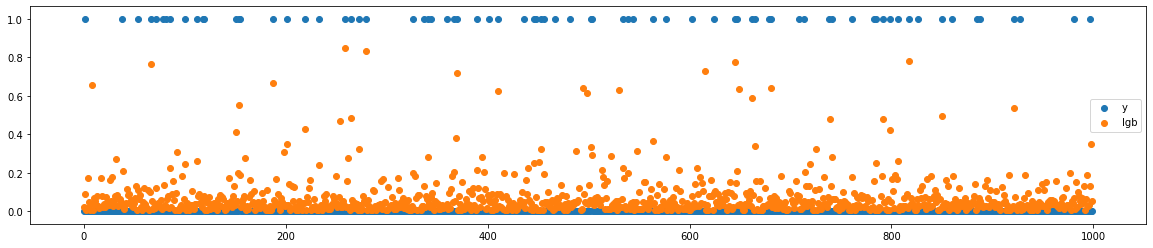

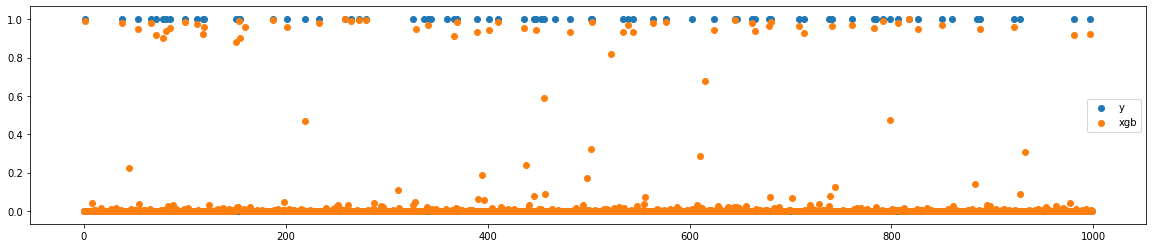

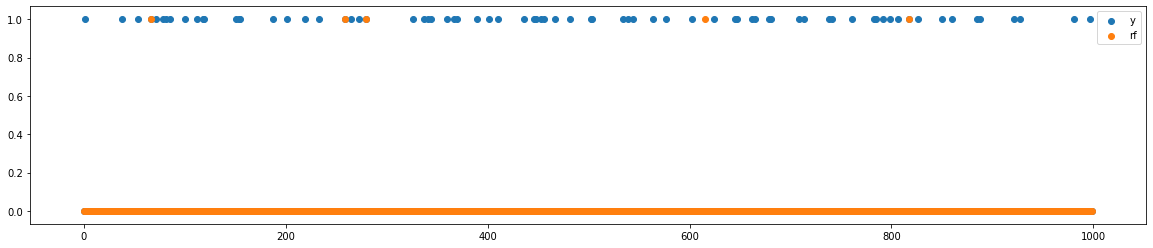

In [110]:
for col in all_pred.drop('y', axis=1).columns:
    plt.figure(figsize=(20, 4))
    plt.scatter(all_pred.index[:1000], all_pred['y'][:1000], alpha=1, label='y')
    plt.scatter(all_pred.index[:1000], all_pred[col][:1000], alpha=1, label=col)
    plt.legend()

## スタッキング

In [111]:
all_pred_train = all_pred[all_pred['y'] != -999]

X = all_pred_train.drop('y', axis=1)
y = all_pred_train['y']

In [112]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((20325, 3), (6775, 3), (20325,), (6775,))

### LightGBM

In [113]:
st_lgb_train = lgb.Dataset(X_train, y_train)
st_lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgb_params = {
    'objective': 'binary', 
    'random_state': 1,
}

st_lgb_model = lgb.train(
    lgb_params, st_lgb_train,
    valid_sets=[st_lgb_train, st_lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.107935	valid_1's binary_logloss: 0.11094
[20]	training's binary_logloss: 0.0829768	valid_1's binary_logloss: 0.0890125
[30]	training's binary_logloss: 0.0738741	valid_1's binary_logloss: 0.0835574
[40]	training's binary_logloss: 0.069514	valid_1's binary_logloss: 0.0823287
[50]	training's binary_logloss: 0.0669219	valid_1's binary_logloss: 0.0826171
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0692272	valid_1's binary_logloss: 0.0823282


In [115]:
all_pred

,y,lgb,xgb,rf
0,0,0.020559,0.000019,0
1,1,0.092102,0.988375,0
2,0,0.007376,0.000003,0
3,0,0.016858,0.000006,0
4,0,0.172752,0.000390,0
...,...,...,...,...
18045,-999,0.022991,0.000003,0
18046,-999,0.008108,0.000004,0
18047,-999,0.067578,0.024460,0
18048,-999,0.011797,0.000001,0


In [117]:
all_pred['st_lgb'] = st_lgb_model.predict(all_pred[['lgb', 'xgb', 'rf']])
all_pred['st_lgb']

0        0.002513
1        0.981463
2        0.001746
3        0.001746
4        0.033360
           ...   
18045    0.008572
18046    0.001746
18047    0.033680
18048    0.001746
18049    0.049022
Name: st_lgb, Length: 45150, dtype: float64

In [48]:
# metrics.roc_auc_score(all_pred['y'], st_y_pred)

# # default : 0.8812548962896131

### XGBoost

In [118]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'seed': 1,
    'eval_metric': 'auc',
}

# モデルを学習する
st_xgb_model = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=1000,
)

[0]	train-auc:0.95343	eval-auc:0.95230
[1]	train-auc:0.95617	eval-auc:0.95471
[2]	train-auc:0.95695	eval-auc:0.95491
[3]	train-auc:0.95719	eval-auc:0.95528
[4]	train-auc:0.96105	eval-auc:0.95781
[5]	train-auc:0.96207	eval-auc:0.95807
[6]	train-auc:0.96237	eval-auc:0.95767
[7]	train-auc:0.96369	eval-auc:0.95744
[8]	train-auc:0.96456	eval-auc:0.95696
[9]	train-auc:0.96538	eval-auc:0.95709
[10]	train-auc:0.96713	eval-auc:0.95712
[11]	train-auc:0.97059	eval-auc:0.95743
[12]	train-auc:0.97215	eval-auc:0.95753
[13]	train-auc:0.97300	eval-auc:0.95724
[14]	train-auc:0.97438	eval-auc:0.95625
[15]	train-auc:0.97475	eval-auc:0.95615
[16]	train-auc:0.97525	eval-auc:0.95609
[17]	train-auc:0.97585	eval-auc:0.95586
[18]	train-auc:0.97662	eval-auc:0.95614
[19]	train-auc:0.97713	eval-auc:0.95649
[20]	train-auc:0.97748	eval-auc:0.95649
[21]	train-auc:0.97814	eval-auc:0.95594
[22]	train-auc:0.97823	eval-auc:0.95622
[23]	train-auc:0.97871	eval-auc:0.95608
[24]	train-auc:0.97876	eval-auc:0.95607
[25]	train

[203]	train-auc:0.99625	eval-auc:0.95263
[204]	train-auc:0.99626	eval-auc:0.95263
[205]	train-auc:0.99630	eval-auc:0.95261
[206]	train-auc:0.99635	eval-auc:0.95249
[207]	train-auc:0.99635	eval-auc:0.95249
[208]	train-auc:0.99635	eval-auc:0.95249
[209]	train-auc:0.99636	eval-auc:0.95237
[210]	train-auc:0.99640	eval-auc:0.95234
[211]	train-auc:0.99641	eval-auc:0.95241
[212]	train-auc:0.99645	eval-auc:0.95240
[213]	train-auc:0.99651	eval-auc:0.95247
[214]	train-auc:0.99652	eval-auc:0.95243
[215]	train-auc:0.99652	eval-auc:0.95243
[216]	train-auc:0.99657	eval-auc:0.95238
[217]	train-auc:0.99660	eval-auc:0.95227
[218]	train-auc:0.99660	eval-auc:0.95227
[219]	train-auc:0.99660	eval-auc:0.95228
[220]	train-auc:0.99661	eval-auc:0.95226
[221]	train-auc:0.99663	eval-auc:0.95218
[222]	train-auc:0.99663	eval-auc:0.95212
[223]	train-auc:0.99663	eval-auc:0.95219
[224]	train-auc:0.99663	eval-auc:0.95216
[225]	train-auc:0.99666	eval-auc:0.95222
[226]	train-auc:0.99666	eval-auc:0.95218
[227]	train-auc:

[403]	train-auc:0.99933	eval-auc:0.94898
[404]	train-auc:0.99933	eval-auc:0.94924
[405]	train-auc:0.99933	eval-auc:0.94920
[406]	train-auc:0.99933	eval-auc:0.94922
[407]	train-auc:0.99934	eval-auc:0.94920
[408]	train-auc:0.99934	eval-auc:0.94920
[409]	train-auc:0.99934	eval-auc:0.94922
[410]	train-auc:0.99935	eval-auc:0.94917
[411]	train-auc:0.99935	eval-auc:0.94912
[412]	train-auc:0.99937	eval-auc:0.94901
[413]	train-auc:0.99938	eval-auc:0.94898
[414]	train-auc:0.99939	eval-auc:0.94903
[415]	train-auc:0.99940	eval-auc:0.94908
[416]	train-auc:0.99940	eval-auc:0.94905
[417]	train-auc:0.99941	eval-auc:0.94900
[418]	train-auc:0.99942	eval-auc:0.94896
[419]	train-auc:0.99942	eval-auc:0.94897
[420]	train-auc:0.99942	eval-auc:0.94909
[421]	train-auc:0.99943	eval-auc:0.94924
[422]	train-auc:0.99943	eval-auc:0.94922
[423]	train-auc:0.99943	eval-auc:0.94924
[424]	train-auc:0.99946	eval-auc:0.94947
[425]	train-auc:0.99947	eval-auc:0.94957
[426]	train-auc:0.99949	eval-auc:0.94944
[427]	train-auc:

[603]	train-auc:0.99995	eval-auc:0.94803
[604]	train-auc:0.99995	eval-auc:0.94811
[605]	train-auc:0.99995	eval-auc:0.94819
[606]	train-auc:0.99995	eval-auc:0.94817
[607]	train-auc:0.99995	eval-auc:0.94823
[608]	train-auc:0.99995	eval-auc:0.94821
[609]	train-auc:0.99995	eval-auc:0.94809
[610]	train-auc:0.99995	eval-auc:0.94800
[611]	train-auc:0.99995	eval-auc:0.94803
[612]	train-auc:0.99995	eval-auc:0.94802
[613]	train-auc:0.99995	eval-auc:0.94802
[614]	train-auc:0.99995	eval-auc:0.94802
[615]	train-auc:0.99995	eval-auc:0.94806
[616]	train-auc:0.99995	eval-auc:0.94812
[617]	train-auc:0.99995	eval-auc:0.94815
[618]	train-auc:0.99995	eval-auc:0.94818
[619]	train-auc:0.99995	eval-auc:0.94820
[620]	train-auc:0.99995	eval-auc:0.94818
[621]	train-auc:0.99995	eval-auc:0.94816
[622]	train-auc:0.99995	eval-auc:0.94816
[623]	train-auc:0.99995	eval-auc:0.94812
[624]	train-auc:0.99995	eval-auc:0.94812
[625]	train-auc:0.99995	eval-auc:0.94813
[626]	train-auc:0.99995	eval-auc:0.94813
[627]	train-auc:

[803]	train-auc:1.00000	eval-auc:0.94546
[804]	train-auc:1.00000	eval-auc:0.94541
[805]	train-auc:1.00000	eval-auc:0.94541
[806]	train-auc:1.00000	eval-auc:0.94537
[807]	train-auc:1.00000	eval-auc:0.94535
[808]	train-auc:1.00000	eval-auc:0.94538
[809]	train-auc:1.00000	eval-auc:0.94535
[810]	train-auc:1.00000	eval-auc:0.94534
[811]	train-auc:1.00000	eval-auc:0.94534
[812]	train-auc:1.00000	eval-auc:0.94531
[813]	train-auc:1.00000	eval-auc:0.94531
[814]	train-auc:1.00000	eval-auc:0.94531
[815]	train-auc:1.00000	eval-auc:0.94530
[816]	train-auc:1.00000	eval-auc:0.94530
[817]	train-auc:1.00000	eval-auc:0.94528
[818]	train-auc:1.00000	eval-auc:0.94529
[819]	train-auc:1.00000	eval-auc:0.94527
[820]	train-auc:1.00000	eval-auc:0.94527
[821]	train-auc:1.00000	eval-auc:0.94536
[822]	train-auc:1.00000	eval-auc:0.94539
[823]	train-auc:1.00000	eval-auc:0.94536
[824]	train-auc:1.00000	eval-auc:0.94532
[825]	train-auc:1.00000	eval-auc:0.94528
[826]	train-auc:1.00000	eval-auc:0.94527
[827]	train-auc:

In [121]:
all_pred['st_xgb'] = st_xgb_model.predict(xgb.DMatrix(all_pred[['lgb', 'xgb', 'rf']]))
all_pred['st_xgb']

0        0.000367
1        0.999424
2        0.000027
3        0.000186
4        0.008077
           ...   
18045    0.001114
18046    0.000017
18047    0.000337
18048    0.000013
18049    0.004898
Name: st_xgb, Length: 45150, dtype: float32

### Ridge

In [122]:
from sklearn.linear_model import RidgeClassifier

In [123]:
ridge_model = RidgeClassifier(tol=1e-2, solver="sag")
ridge_model.fit(X, y)

stack_models.append(ridge_model)
ridge_y_pred = ridge_model.predict(X)

all_pred['st_ridge'] = ridge_model.predict(all_pred[['lgb', 'xgb', 'rf']])
all_pred['st_ridge']


0        0
1        1
2        0
3        0
4        0
        ..
18045    0
18046    0
18047    0
18048    0
18049    0
Name: st_ridge, Length: 45150, dtype: int64

In [124]:
all_pred

,y,lgb,xgb,rf,st_lgb,st_xgb,st_ridge
0,0,0.020559,0.000019,0,0.002513,0.000367,0
1,1,0.092102,0.988375,0,0.981463,0.999424,1
2,0,0.007376,0.000003,0,0.001746,0.000027,0
3,0,0.016858,0.000006,0,0.001746,0.000186,0
4,0,0.172752,0.000390,0,0.033360,0.008077,0
...,...,...,...,...,...,...,...
18045,-999,0.022991,0.000003,0,0.008572,0.001114,0
18046,-999,0.008108,0.000004,0,0.001746,0.000017,0
18047,-999,0.067578,0.024460,0,0.033680,0.000337,0
18048,-999,0.011797,0.000001,0,0.001746,0.000013,0


In [125]:
# metrics.roc_auc_score(all_pred['y'], ridge_y_pred)

# default : 0.8812548962896131

In [126]:
all_pred.corr()

,y,lgb,xgb,rf,st_lgb,st_xgb,st_ridge
y,1.000000,0.003678,0.049886,0.000592,0.061521,0.071630,0.062432
lgb,0.003678,1.000000,0.635621,0.499164,0.676646,0.618342,0.590343
xgb,0.049886,0.635621,1.000000,0.339194,0.964344,0.883928,0.965475
rf,0.000592,0.499164,0.339194,1.000000,0.345843,0.326321,0.323431
st_lgb,0.061521,0.676646,0.964344,0.345843,1.000000,0.925145,0.915551
st_xgb,0.071630,0.618342,0.883928,0.326321,0.925145,1.000000,0.836507
st_ridge,0.062432,0.590343,0.965475,0.323431,0.915551,0.836507,1.000000


# Grid Search CV(Cross Validation)

In [127]:
parameters = {"max_depth":[2,3,4,5,6,7,8,9,10]}

parameters_lgb = {
    "max_depth": list(range(3,10, 2)),
    "min_samples_leaf": [5,10,20,50,100,500],
    "random_state": [0]
}

parameters_xgb = {
    "max_depth": list(range(3,10, 2)),
    'min_child_weight': range(1,6,2),
    "random_state": [0]
}

parameters_rf = {
    "max_depth": list(range(3,10, 2)),
    "random_state": [0]
}

## Random Forest

In [128]:
clf_rf = RandomForestClassifier()

gcv_rf = GridSearchCV(clf_rf, parameters_rf, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv_rf.fit(X_train_org, y_train_org)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [129]:
gcv_rf.cv_results_

{'mean_fit_time': array([1.30511298, 1.79480214, 2.1179378 , 2.1574307 ]),
 'std_fit_time': array([0.06110797, 0.07582166, 0.04466791, 0.17348392]),
 'mean_score_time': array([0.06143413, 0.07001252, 0.08517466, 0.06702056]),
 'std_score_time': array([0.00466131, 0.00375309, 0.01384328, 0.00984074]),
 'param_max_depth': masked_array(data=[3, 5, 7, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_random_state': masked_array(data=[0, 0, 0, 0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 3, 'random_state': 0},
  {'max_depth': 5, 'random_state': 0},
  {'max_depth': 7, 'random_state': 0},
  {'max_depth': 9, 'random_state': 0}],
 'split0_test_score': array([0.78990791, 0.80003068, 0.81429349, 0.81976772]),
 'split1_test_score': array([0.79421887, 0.80811614, 0.81754574, 0.82572555]),
 'split2_test_score': array([0.78037044, 0.79696879, 0.80963641,

([<matplotlib.axis.XTick at 0x1f97849e388>,
 <a list of 9 Text xticklabel objects>)

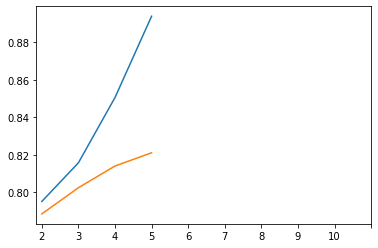

In [130]:
train_score = gcv_rf.cv_results_['mean_train_score']
test_score = gcv_rf.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

In [131]:
stack_models.append(gcv_rf)
cv_rf_pred = gcv_rf.predict(X_train_org)

all_pred['cv_rf'] = gcv_rf.predict(X_all)
all_pred['cv_rf']

0        0
1        0
2        0
3        0
4        0
        ..
18045    0
18046    0
18047    0
18048    0
18049    0
Name: cv_rf, Length: 45150, dtype: int64

## LightGBM

In [132]:
clf_lgb = lgb.LGBMClassifier()

gcv_lgb = GridSearchCV(clf_lgb, parameters_lgb, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv_lgb.fit(X_train_org, y_train_org)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf':

In [133]:
gcv_lgb.cv_results_

{'mean_fit_time': array([0.38856044, 0.4031198 , 0.37758918, 0.379983  , 0.38796239,
        0.39315071, 0.53855901, 0.54194975, 0.52459617, 0.51921096,
        0.5742641 , 0.56449027, 0.61834645, 0.6353003 , 0.62712255,
        0.61136503, 0.61096544, 0.60817313, 0.7196754 , 0.61794777,
        0.59600396, 0.61774821, 0.60517907, 0.57506127]),
 'std_fit_time': array([0.01490764, 0.01257457, 0.01611403, 0.00827248, 0.0107795 ,
        0.01567419, 0.00991423, 0.01736138, 0.01439754, 0.03425148,
        0.04664511, 0.03274482, 0.02636364, 0.01169909, 0.02591148,
        0.02882228, 0.02426255, 0.06228582, 0.01676638, 0.04493888,
        0.00587099, 0.02174659, 0.03362397, 0.02273006]),
 'mean_score_time': array([0.05006595, 0.05226021, 0.06363015, 0.0490684 , 0.05505228,
        0.04966493, 0.06662159, 0.06781907, 0.07101064, 0.06821823,
        0.0716105 , 0.07958717, 0.07739239, 0.0759973 , 0.08238025,
        0.0831779 , 0.07898893, 0.07719498, 0.08976021, 0.07180743,
        0.068018

([<matplotlib.axis.XTick at 0x1f978d67548>,
 <a list of 9 Text xticklabel objects>)

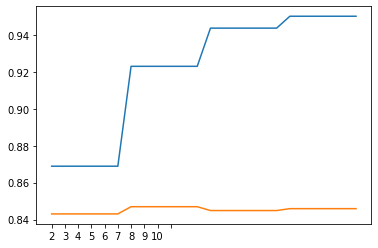

In [134]:
train_score = gcv_lgb.cv_results_['mean_train_score']
test_score = gcv_lgb.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

In [135]:
stack_models.append(gcv_lgb)
cv_lgb_pred = gcv_lgb.predict(X_train_org)

all_pred['cv_lgb'] = gcv_lgb.predict(X_all)
all_pred['cv_lgb']

0        0
1        0
2        0
3        0
4        0
        ..
18045    0
18046    0
18047    0
18048    0
18049    0
Name: cv_lgb, Length: 45150, dtype: int64

## XGBoost

In [136]:
clf_xgb = xgb.XGBClassifier()

gcv_xgb = GridSearchCV(clf_xgb, parameters_xgb, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv_xgb.fit(X_train_org, y_train_org)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [137]:
gcv_xgb.cv_results_

{'mean_fit_time': array([3.57623873, 3.14000421, 2.62677636, 4.1026298 , 4.0110764 ,
        3.96799068, 5.6064106 , 5.53420172, 5.50867171, 7.25619936,
        7.0738874 , 5.82502718]),
 'std_fit_time': array([0.14131762, 0.42321693, 0.02581775, 0.04684065, 0.08135079,
        0.054278  , 0.05924992, 0.02825927, 0.03937431, 0.05861968,
        0.12810049, 0.28003974]),
 'mean_score_time': array([0.03211412, 0.02573137, 0.03151498, 0.04069142, 0.04288497,
        0.0418879 , 0.06382952, 0.05604978, 0.05644898, 0.07599654,
        0.06362953, 0.05884757]),
 'std_score_time': array([0.00996124, 0.00239313, 0.00425909, 0.00171588, 0.00769946,
        0.00315369, 0.00679438, 0.00305133, 0.00506944, 0.00586314,
        0.00734091, 0.00588122]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object

([<matplotlib.axis.XTick at 0x1f97aa1e5c8>,
 <a list of 9 Text xticklabel objects>)

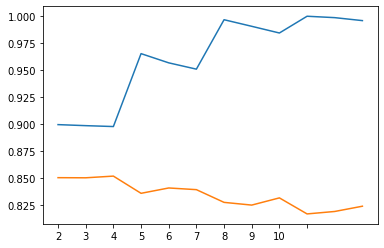

In [138]:
train_score = gcv_xgb.cv_results_['mean_train_score']
test_score = gcv_xgb.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

In [139]:
stack_models.append(gcv_xgb)
cv_xgb_pred = gcv_xgb.predict(X_train_org)

all_pred['cv_xgb'] = gcv_xgb.predict(X_all)
all_pred['cv_xgb']

0        0
1        0
2        0
3        0
4        0
        ..
18045    0
18046    0
18047    0
18048    0
18049    0
Name: cv_xgb, Length: 45150, dtype: int64

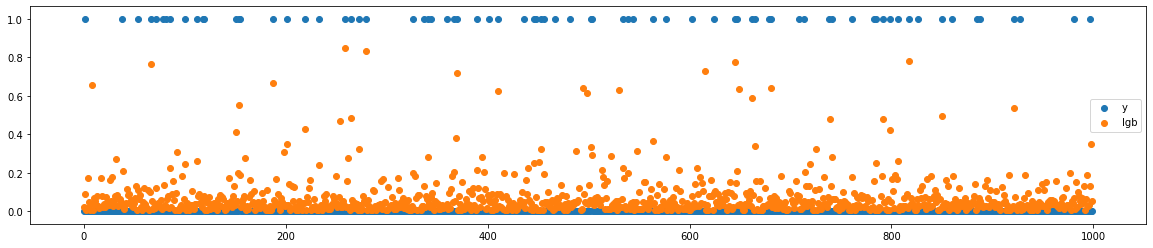

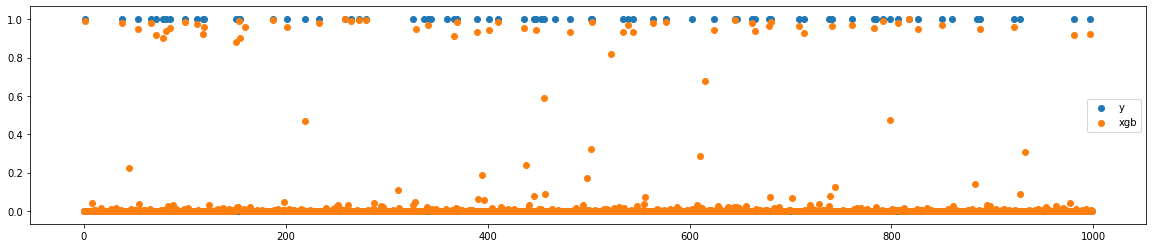

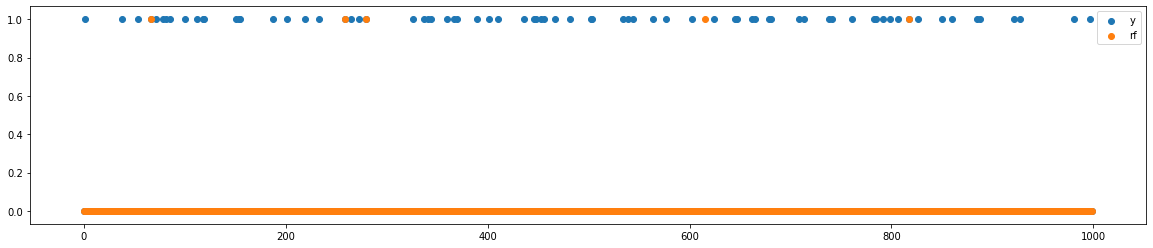

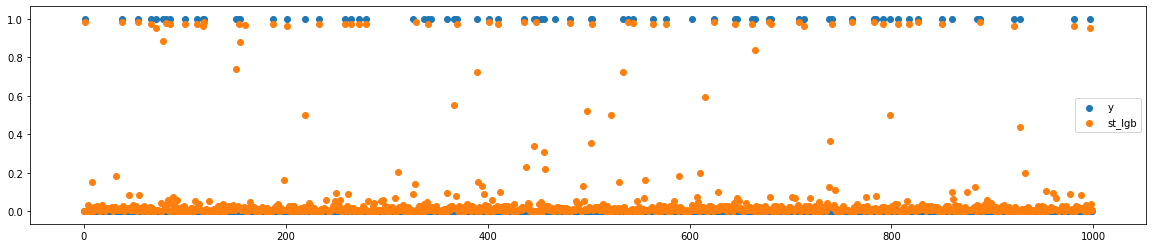

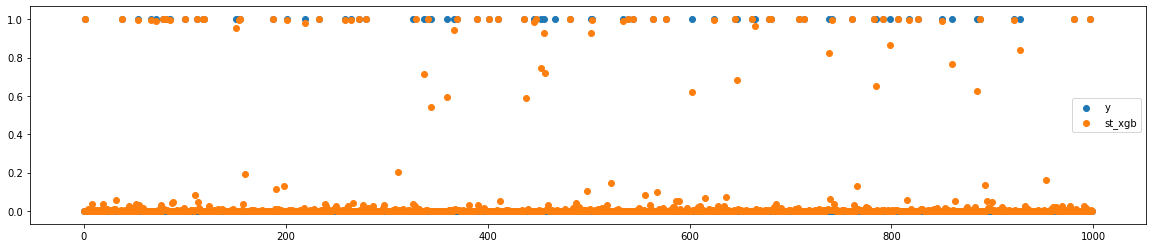

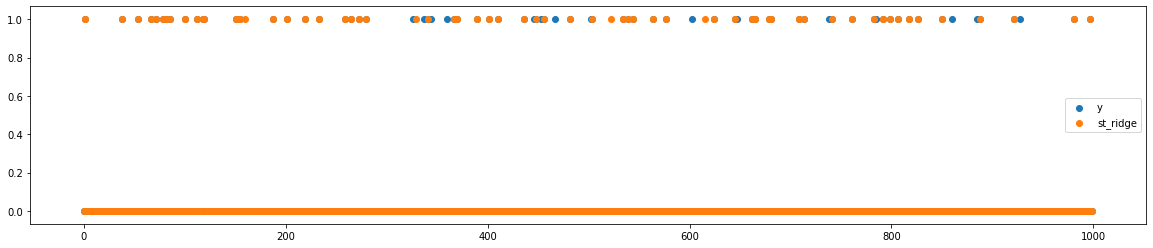

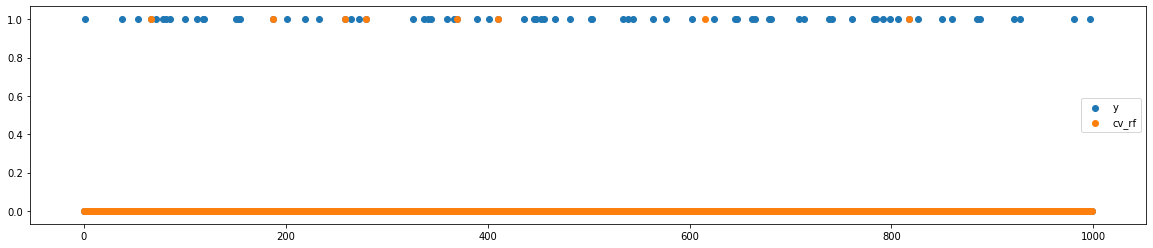

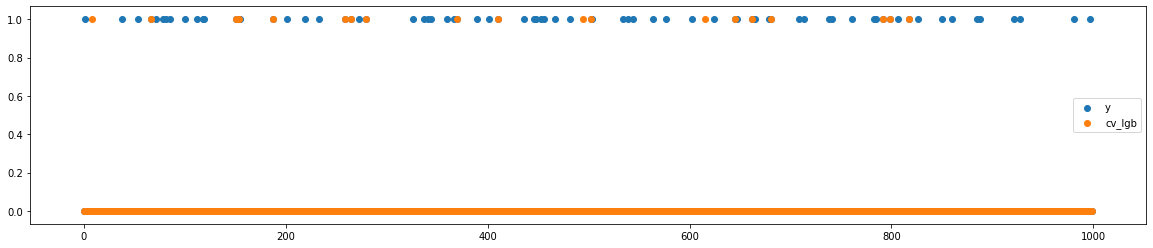

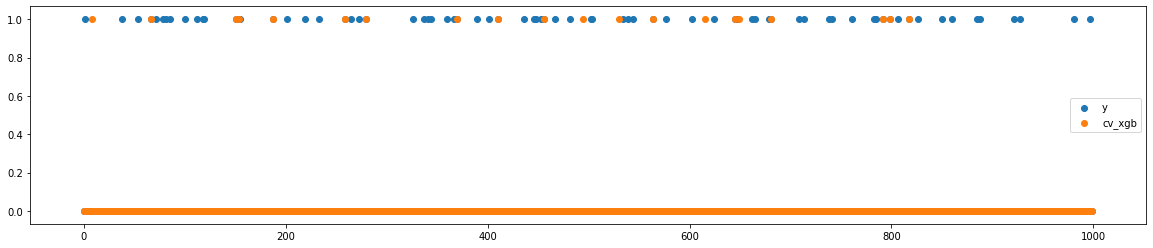

In [140]:
for col in all_pred.drop('y', axis=1).columns:
    plt.figure(figsize=(20, 4))
    plt.scatter(all_pred.index[:1000], all_pred['y'][:1000], alpha=1, label='y')
    plt.scatter(all_pred.index[:1000], all_pred[col][:1000], alpha=1, label=col)
    plt.legend()

In [141]:
(216+495)/27100*100

2.623616236162362

In [142]:
(216+495)

711

In [143]:
all_pred_train = all_pred[all_pred['y'] != -999]
all_pred_train.shape

(27100, 10)

In [144]:
all_pred_train[(all_pred_train['y'] == 0) & (all_pred_train['st_ridge'] != 0)]

,y,lgb,xgb,rf,st_lgb,st_xgb,st_ridge,cv_rf,cv_lgb,cv_xgb
160,0,0.276078,0.957894,0,0.968160,0.190413,1,0,0,0
329,0,0.068757,0.950565,0,0.981463,0.999709,1,0,0,0
522,0,0.288898,0.816483,0,0.500426,0.143442,1,0,0,0
615,0,0.731337,0.678622,1,0.596061,0.067916,1,1,1,1
1022,0,0.484260,0.492766,0,0.428492,0.111831,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
26615,0,0.303142,0.517367,0,0.353241,0.004125,1,0,0,0
26734,0,0.802718,0.918850,0,0.788804,0.122372,1,0,1,1
26845,0,0.063927,0.542098,0,0.156757,0.017948,1,0,0,0
26979,0,0.541568,0.980562,0,0.974372,0.193930,1,0,0,1


In [145]:
all_pred_train[(all_pred_train['y'] == 1) & (all_pred_train['st_ridge'] != 1)]

,y,lgb,xgb,rf,st_lgb,st_xgb,st_ridge,cv_rf,cv_lgb,cv_xgb
326,1,0.201083,0.031536,0,0.089109,0.035477,0,0,0,0
337,1,0.130034,0.000367,0,0.036198,0.715418,0,0,0,0
344,1,0.072375,0.004848,0,0.024288,0.543884,0,0,0,0
360,1,0.036293,0.000197,0,0.093730,0.591893,0,0,0,0
446,1,0.250259,0.075495,0,0.337984,0.988002,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
26878,1,0.645325,0.107077,0,0.397597,0.951690,0,1,1,1
26930,1,0.143146,0.007583,0,0.022739,0.004988,0,0,0,0
26947,1,0.179353,0.009356,0,0.031392,0.573623,0,0,0,0
26978,1,0.037399,0.000014,0,0.101482,0.763014,0,0,0,0


In [146]:
all_pred_train['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [147]:
### 提出用
## スタッキング

# X = all_pred.drop('y', axis=1)
# y = all_pred['y']

# X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# st_lgb_train = lgb.Dataset(X_train, y_train)
# st_lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# lgb_params = {
#     'objective': 'binary', 
#     'random_state': 1,
# }

# st_lgb_model = lgb.train(
#     lgb_params, st_lgb_train,
#     valid_sets=[st_lgb_train, st_lgb_eval],
#     verbose_eval=10,
#     num_boost_round=1000,
#     early_stopping_rounds=10
# )

# st_y_pred = st_lgb_model.predict(X)
# st_y_pred

In [151]:
all_pred[all_pred['y'] == -999]['st_xgb']

0        0.874646
1        0.071835
2        0.008805
3        0.000033
4        0.006051
           ...   
18045    0.001114
18046    0.000017
18047    0.000337
18048    0.000013
18049    0.004898
Name: st_xgb, Length: 18050, dtype: float32

In [153]:
np.where(all_pred[all_pred['y'] == -999]['st_xgb'] > 0.5, 1, 0)

array([1, 0, 0, ..., 0, 0, 0])

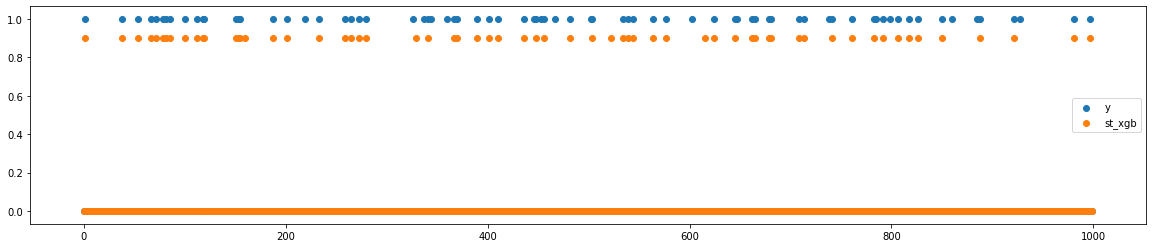

In [159]:
plt.figure(figsize=(20, 4))
plt.scatter(all_pred.index[:1000], all_pred['y'][:1000], alpha=1, label='y')
plt.scatter(all_pred.index[:1000], np.where(all_pred['xgb'] > 0.5, 0.9, 0)[:1000], alpha=1, label='st_xgb')
plt.legend()
plt.show()

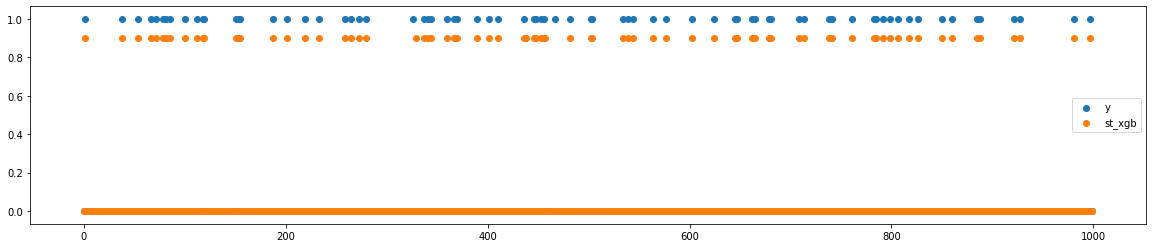

In [160]:
plt.figure(figsize=(20, 4))
plt.scatter(all_pred.index[:1000], all_pred['y'][:1000], alpha=1, label='y')
plt.scatter(all_pred.index[:1000], np.where(all_pred['st_xgb'] > 0.5, 0.9, 0)[:1000], alpha=1, label='st_xgb')
plt.legend()
plt.show()

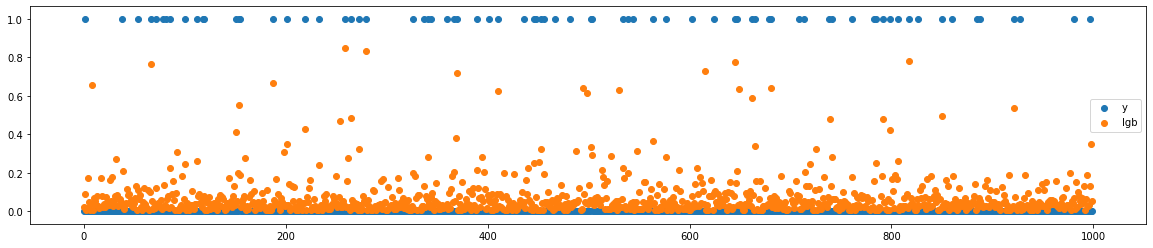

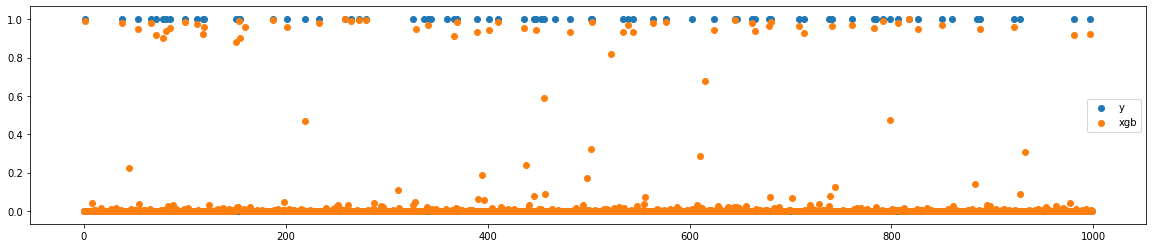

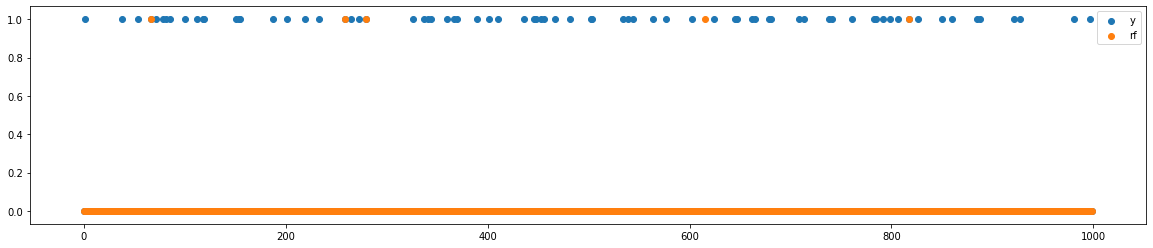

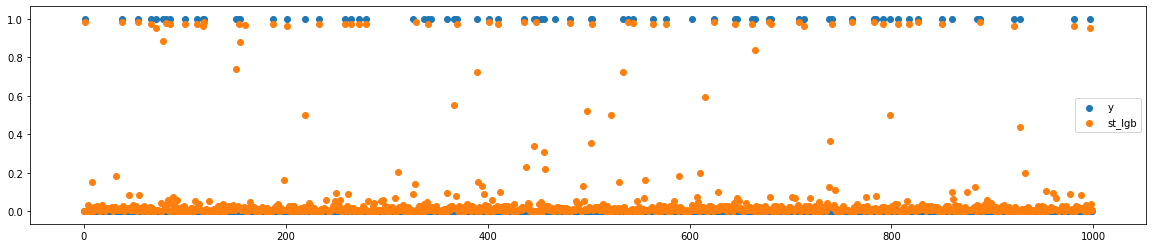

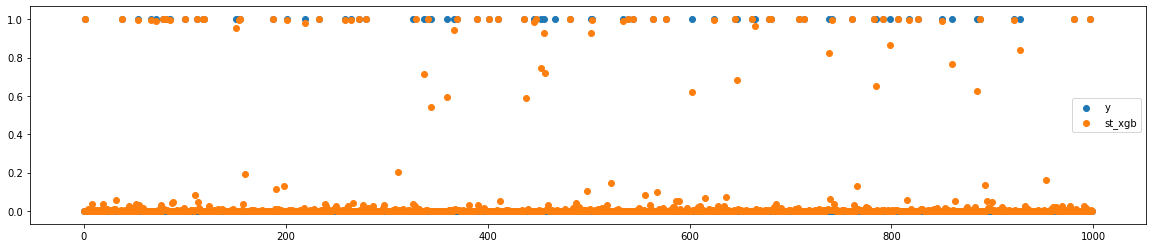

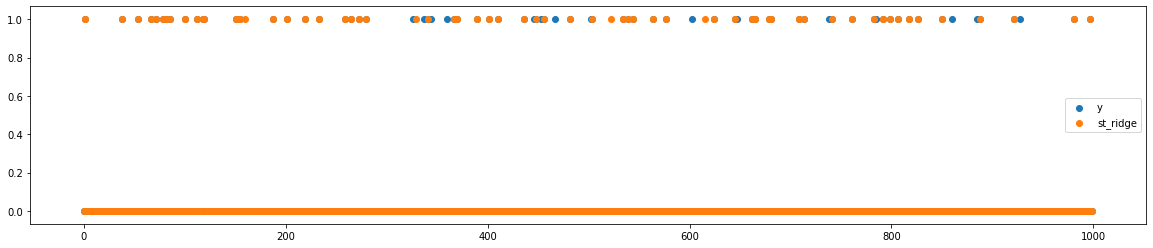

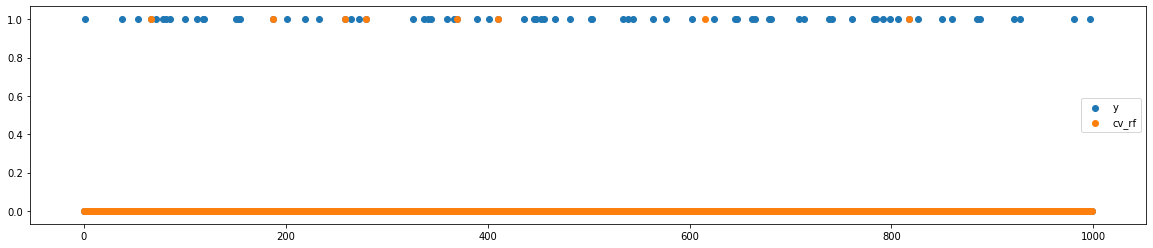

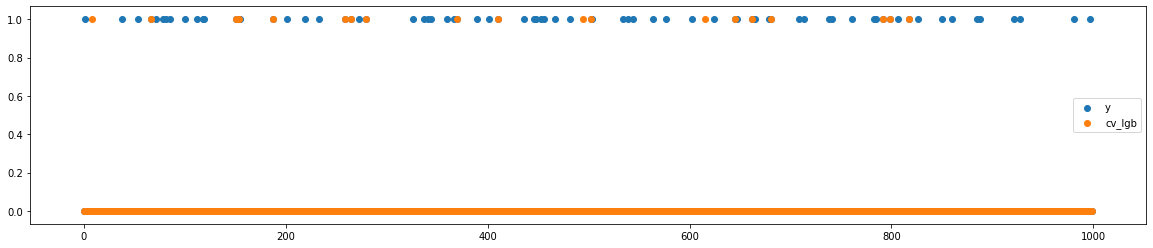

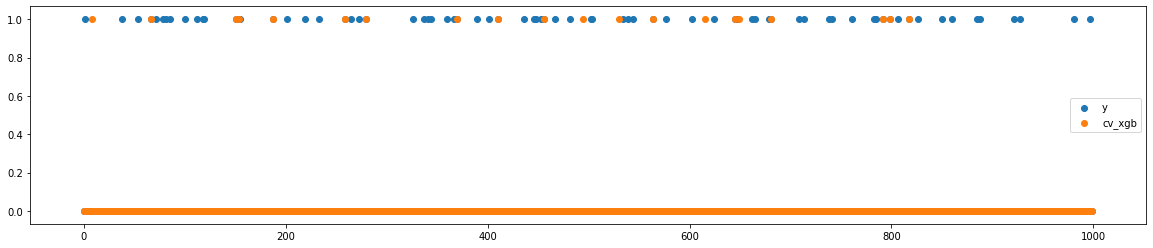

In [156]:
for col in all_pred.drop('y', axis=1).columns:
    plt.figure(figsize=(20, 4))
    plt.scatter(all_pred.index[:1000], all_pred['y'][:1000], alpha=1, label='y')
    plt.scatter(all_pred.index[:1000], all_pred[col][:1000], alpha=1, label=col)
    plt.legend()

In [152]:
submit_df[1]=np.where(all_pred[all_pred['y'] == -999]['st_xgb'] > 0.5, 1, 0)
submit_df.to_csv('submit_20200808_st_xgb.csv',index=False,header=None)
